# Combine GPX and UV track to yield a KML file

## Imports

In [1]:
import datetime
import gpxpy
import json
import matplotlib.dates as mdate
import matplotlib.pyplot as plt
import pytz
import sys
from simplekml import Kml


## Initial Settings

In [12]:
# file_forecast = "2024-05-06_uv-forecast.json"
# file_gpx = "2024-04-13_12-44.gpx"
# file_uvbg= "2024-05-06_uvbg.csv"

file_gpx = "2023-06-18_13-43.gpx" # "2024-05-05_14-58.gpx" # "2024-05-05_08-51.gpx"
file_uvbg= "2023-06-18_uvbg.csv"  # "2024-05-05_uvbg.csv"
kml_outfilename = "2024-05-05_uvbg_Ammersee.kml"


## Functions

In [13]:
colors=["ff007700", "ff00ff00", "ff00ff77", "ff0044ff", "ff007777", "ff00ffff", "ff0077ff", "ff0044ff", "ff0000ff", "ff7700ff", "ffff00ff"]

In [14]:
def howto_forecast():
    print ("wget https://ren27oydli.execute-api.eu-central-1.amazonaws.com/prod\?lon=11.5\&lat=48.5\&tz=-120\&secret=UV-Bodyguard -O `date +'%Y%m%d'`_uv-forecast.json")


In [15]:
# Web download from:
# https://ren27oydli.execute-api.eu-central-1.amazonaws.com/prod?lon=11.5&lat=48.5&tz=-120&secret=UV-Bodyguard
def read_forecast(file_forecast):
    file_forecast_handle = open (file_forecast, "r")
    uv_forecast = json.load(file_forecast_handle)["uv"]

    uv_forecast_dates = []
    uv_forecast_value = []

    for item in uv_forecast:
        uv_forecast_dates.append (datetime.datetime.fromtimestamp(int(item["time"])-7200))
        uv_forecast_value.append (float(item["value"]))
    
    return uv_forecast_dates, uv_forecast_value


In [16]:
def read_uvbg(file_uvbg):
    file_handle = open (file_uvbg, "r")
    lines = file_handle.readlines()
    file_handle.close()

    uvbg_dates = []
    uvbg_value = []
    uvtrack = []
    
    for line in lines:
        items = line.split(",")
        xtime_dt = datetime.datetime.fromtimestamp(int(items[0])/1000-7200)
        uvbg_dates.append(xtime_dt)
        xuvi = float(items[1])
        uvbg_value.append(xuvi)
        
        uvtrack.append({"time": xtime_dt.replace(tzinfo=pytz.UTC), "uvi": xuvi})
        
    x = uvbg_dates[0]
    xyyyy = int(x.strftime("%Y"))
    xmm = int(x.strftime("%m"))
    xdd = int(x.strftime("%d"))
    xtoday = datetime.datetime (xyyyy, xmm, xdd, 0, 0, 0)
    
    print ("UV Track: First/last: ", uvtrack[0]["time"], uvtrack[-1]["time"])
        
    return uvbg_dates, uvbg_value, xtoday, uvtrack


In [17]:
def read_gpx(file_gpx):

    gpx = gpxpy.parse(open(file_gpx), "r")

    geotrack = []
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                geotrack.append({"time": point.time, "lon": point.longitude, "lat": point.latitude, "elevation": point.elevation, "uvi": -1})
                # print('Point at ({0},{1},{2}) -> {3}'.format(point.time, point.latitude, point.longitude, point.elevation))
    
    print ("GPX track: First/last: ", geotrack[0]["time"], geotrack[-1]["time"])
    
    return geotrack


In [18]:
def combine_gpx_uvtrack(geotrack, uvtrack, kml_outfilename):
    
    nelements = len(geotrack)
    ielement  = 0
    
    print ("")
    
    for g in geotrack:
        print("\r", ielement/nelements*100, "%", end="")
              
        xgeotime = g["time"]

        xdeltat = []
        for uv in uvtrack:
            xdeltat.append (abs(uv["time"] - xgeotime))

        xmindeltat = min (xdeltat)
        i = xdeltat.index (xmindeltat)

        g["uvi"] = uvtrack[i]["uvi"]
              
        ielement += 1

    kml = Kml()
    fol = kml.newfolder(name="A Folder")
    for g in geotrack:
        pnt = fol.newpoint(name="{0}".format(int(g["uvi"])), coords=[(g["lon"],g["lat"])])
        uv_index = int(g["uvi"])
        if uv_index > 11: uv_index = 11
        pnt.style.iconstyle.color = colors[uv_index] # float(float(uv_index) / 3.0)
        pnt.style.iconstyle.icon.href = "http://maps.google.com/mapfiles/kml/shapes/road_shield3.png"
        # Shapes can be found here: https://kml4earth.appspot.com/icons.html#shapes

    kml.save(kml_outfilename)
    
    print ("\n\nKML file written to ", kml_outfilename)
    
    print ("\nYou may use https://kmzview.com/ or https://earth.google.com for visualization of KML file.\n"
    

In [19]:
def plot_uvbg(uvbg_dates, uvbg_value, xtoday):

    fig, ax = plt.subplots()

    # Plot the date using plot_date rather than plot
    ax.plot_date(uvbg_dates, uvbg_value, ".")

    xtoday_min = xtoday + datetime.timedelta(0,  9*60*60)
    xtoday_max = xtoday + datetime.timedelta(0, 21*60*60)
    
    ax.set_xlim(xtoday_min, xtoday_max)

    # Choose your xtick format string
    date_fmt = '%H'

    # Use a DateFormatter to set the data to the correct format.
    # date_formatter = mdate.DateFormatter(date_fmt)
    # ax.xaxis.set_major_formatter(date_formatter)
    ax.xaxis.set_major_formatter(mdate.DateFormatter('%H'))
    
    ax.set_title (xtoday.strftime("%Y-%m-%d"))

    # Sets the tick labels diagonal so they fit easier.
    fig.autofmt_xdate()
    

In [20]:
def plot_forecast_uvbg(uv_forecast_dates, uv_forecast_value, uvbg_dates, uvbg_value, xtoday):

    fig, ax = plt.subplots()

    # Plot the date using plot_date rather than plot
    ax.plot_date(uv_forecast_dates, uv_forecast_value, "-")
    ax.plot_date(uvbg_dates, uvbg_value, ".")

    xtoday_min = xtoday + datetime.timedelta(0,  9*60*60)
    xtoday_max = xtoday + datetime.timedelta(0, 21*60*60)
    
    ax.set_xlim(xtoday_min, xtoday_max)

    # Choose your xtick format string
    date_fmt = '%H'

    # Use a DateFormatter to set the data to the correct format.
    # date_formatter = mdate.DateFormatter(date_fmt)
    # ax.xaxis.set_major_formatter(date_formatter)
    ax.xaxis.set_major_formatter(mdate.DateFormatter('%H'))
    
    ax.set_title (xtoday.strftime("%Y-%m-%d"))

    # Sets the tick labels diagonal so they fit easier.
    fig.autofmt_xdate()
    

## Main

wget https://ren27oydli.execute-api.eu-central-1.amazonaws.com/prod\?lon=11.5\&lat=48.5\&tz=-120\&secret=UV-Bodyguard -O `date +'%Y%m%d'`_uv-forecast.json
UV Track: First/last:  2023-06-18 11:41:13.889000+00:00 2023-06-18 17:28:46.706000+00:00
GPX track: First/last:  2023-06-18 11:43:09.706000+00:00 2023-06-18 17:25:18.238000+00:00

 99.96102883865939 %%%

KML file written to  2024-05-05_uvbg_Ammersee.kml


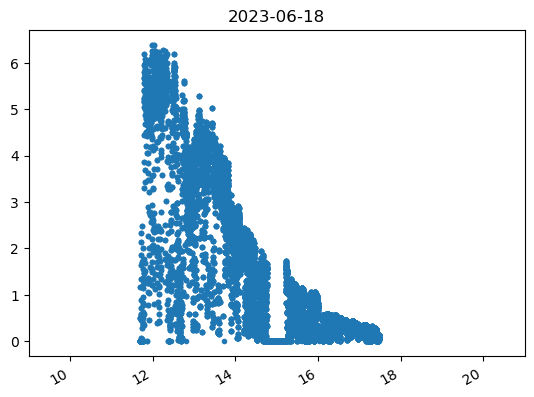

In [21]:
howto_forecast()
# uv_forecast_dates, uv_forecast_value = read_forecast(file_forecast)
uvbg_dates, uvbg_value, xtoday, uvtrack = read_uvbg(file_uvbg)
# plot_forecast_uvbg(uv_forecast_dates, uv_forecast_value, uvbg_dates, uvbg_value, xtoday)
geotrack = read_gpx(file_gpx)
plot_uvbg(uvbg_dates, uvbg_value, xtoday)

combine_gpx_uvtrack(geotrack, uvtrack, kml_outfilename)
